In [10]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Epoch 2:  88%|████████▊ | 455/520 [00:00<00:00, 689.70batch/s, mse=1.46e+6]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 7:  59%|█████▊    | 305/520 [00:00<00:00, 636.28batch/s, mse=3.63e+5]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 12:  23%|██▎       | 119/520 [00:00<00:00, 739.28batch/s, mse=6.15e+5]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To chang

MSE: 853397.56
RMSE: 923.80


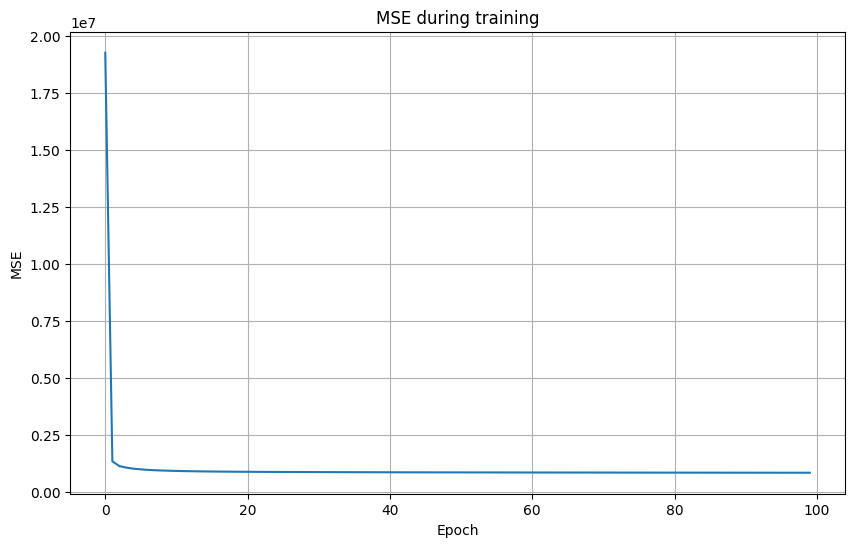

/home/gatien/Bureau/stravanalytics/ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/gatien/Bureau/stravanalytics/ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/gatien/Bureau/stravanalytics/ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/gatien/Bureau/stravanalytics/ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/gatien/Bureau/stravanalytics/ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: U

Features: [np.float64(14033.1) np.float64(65.3) np.float64(131.0) np.True_]
Predicted time: 4415.40 seconds (real data: 4556.00 seconds)
Predicted time: 73.59 minutes (real data: 75.93 minutes)
---
Features: [np.float64(2321.9) np.float64(6.0) np.float64(96.1) np.True_]
Predicted time: 1047.07 seconds (real data: 1067.00 seconds)
Predicted time: 17.45 minutes (real data: 17.78 minutes)
---
Features: [np.float64(8639.3) np.float64(61.0) np.float64(126.8) np.True_]
Predicted time: 2933.30 seconds (real data: 3257.00 seconds)
Predicted time: 48.89 minutes (real data: 54.28 minutes)
---
Features: [np.float64(10678.8) np.float64(109.0) np.float64(148.3) np.True_]
Predicted time: 3356.81 seconds (real data: 3478.00 seconds)
Predicted time: 55.95 minutes (real data: 57.97 minutes)
---
Features: [np.float64(10859.0) np.float64(128.4) np.float64(137.9) np.True_]
Predicted time: 3502.44 seconds (real data: 3171.00 seconds)
Predicted time: 58.37 minutes (real data: 52.85 minutes)
---


In [42]:
# Load the dataset
df = pd.read_csv("../data/raw-data-kaggle.csv", sep=';',
                 header=None,
                 names=['user_id', 'gender', 'datetime', 'distance', 'time', 'elevation_gain', 'average_heart_rate'])

df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df['elevation_gain'] = pd.to_numeric(df['elevation_gain'], errors='coerce')
df['average_heart_rate'] = pd.to_numeric(df['average_heart_rate'], errors='coerce')

# Delete lines with NaN values
df = df.dropna(subset=['distance', 'time', 'elevation_gain', 'average_heart_rate'])

# Select features we want to use
X = df[['distance', 'elevation_gain', 'average_heart_rate', 'gender']]
y = df['time']

# Encode categorical variables
X = pd.get_dummies(X, columns=['gender'], drop_first=True)

# Divide the dataset into training and testing sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=42)

# Scale the features
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

# Define the neural network model
input_size = X_train.shape[1]
model = nn.Sequential(
    nn.Linear(input_size, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train settings
n_epochs = 100
batch_size = 32
batch_start = torch.arange(0, len(X_train), batch_size)

# Initialize variables to track the best model
best_mse = np.inf
best_weights = None
history = []

# Train the model
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # Select a batch of data
            end = min(start + batch_size, len(X_train))
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]

            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Show progress bar
            bar.set_postfix(mse=float(loss))

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

# Load the best model
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))

# View the training history
plt.figure(figsize=(10, 6))
plt.plot(history)
plt.title('MSE during training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

# Test the model on examples
model.eval()
with torch.no_grad():
    for i in range(5):
        X_sample = X_test_raw.iloc[i:i + 1].values
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"Features: {X_test_raw.iloc[i].values}")
        print(f"Predicted time: {y_pred[0].item():.2f} seconds (real data: {y_test[i].item():.2f} seconds)")
        print(f"Predicted time: {y_pred[0].item() / 60:.2f} minutes (real data: {y_test[i].item() / 60:.2f} minutes)")
        print("---")

In [43]:
# Save the model

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': n_epochs,
    'best_mse': best_mse,
    'scaler': scaler,
    'input_size': input_size
}, 'predict_duration_model.pth')

print("Model saved successfully.")

Model saved successfully.


In [44]:
def load_model(path: str):
    model = nn.Sequential(
        nn.Linear(input_size, 24),
        nn.ReLU(),
        nn.Linear(24, 12),
        nn.ReLU(),
        nn.Linear(12, 6),
        nn.ReLU(),
        nn.Linear(6, 1)
    )
    from torch.serialization import add_safe_globals
    from sklearn.preprocessing._data import StandardScaler
    add_safe_globals([StandardScaler])

    checkpoint = torch.load(path, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])

    scaler_charge = checkpoint['scaler']

    model.eval()

    return model, scaler_charge

In [53]:
model, scaler_charge = load_model('predict_duration_model.pth')


def predict_duration(distance, elevation_gain, heart_rate, gender, model, scaler):
    input_data_raw = pd.DataFrame({
        'distance': [distance],
        'elevation_gain': [elevation_gain],
        'average_heart_rate': [heart_rate],
        'gender': [gender]
    })

    input_data = pd.get_dummies(input_data_raw, columns=['gender'], drop_first=True)

    missing_cols = set(scaler.feature_names_in_) - set(input_data.columns)
    for col in missing_cols:
        input_data[col] = 0

    input_data = input_data[scaler.feature_names_in_]

    input_scaled = scaler.transform(input_data)

    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)

    with torch.no_grad():
        prediction = model(input_tensor)

    seconds = prediction.item()
    minutes = seconds / 60

    return seconds, minutes


seconds, minutes = predict_duration(distance=5000, elevation_gain=0, heart_rate=170, gender='M', model=model,
                                    scaler=scaler_charge)
print(f"Predicted duration: {seconds:.2f} seconds ({minutes:.2f} minutes)")

Predicted duration: 1688.11 seconds (28.14 minutes)
